In [1]:
import geopandas as gpd
import numpy as np

import pygmo as pg

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx
%matplotlib inline

In [2]:
n_sensors = 20

## Load Data

Processed in population_data.ipynb notebook.

In [3]:
tyne_oa = gpd.read_file("data/tyne_oa")
tyne_oa.head()

oa11cd    lad11cd           X           Y  Population  \
0  E00042042  E08000021  421259.393  564639.754         310   
1  E00042043  E08000021  420448.616  564819.213         304   
2  E00042044  E08000021  420509.207  564622.209         246   
3  E00042045  E08000021  421551.722  564088.460         201   
4  E00042046  E08000021  422116.597  563648.529         424   

                                            geometry  
0  POLYGON ((421301.772 564928.429, 421301.755 56...  
1  POLYGON ((420572.364 564892.821, 420572.312 56...  
2  POLYGON ((420492.559 564780.806, 420492.590 56...  
3  POLYGON ((421543.715 563955.116, 421542.251 56...  
4  POLYGON ((422292.813 563736.716, 422265.374 56...

In [44]:
print(tyne_oa.X.min(), tyne_oa.X.max())
print(tyne_oa.Y.min(), tyne_oa.Y.max())

413067.0710000005 429849.7170000002
563224.0130000003 577386.1339999996


In [4]:
populations = tyne_oa["Population"]

## Calculate Distances Between Output Areas

In [5]:
centroids = np.array([tyne_oa["X"], tyne_oa["Y"]]).T
centroids.shape

(952, 2)

In [6]:
dist_sq = np.sum((centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)

distances = np.sqrt(dist_sq)

Max distance of 16923.71770783074 m is between E00042743 and E00139704


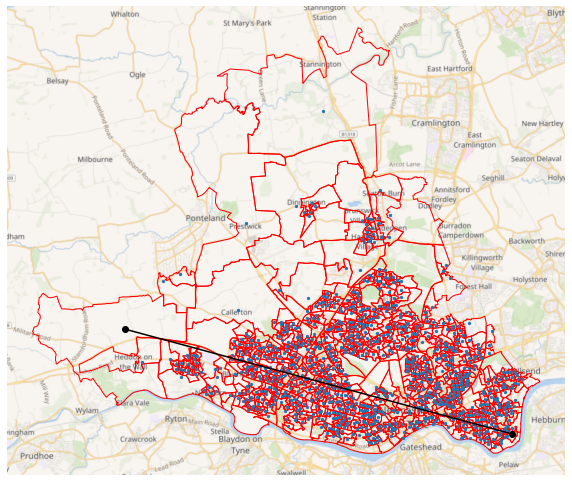

In [7]:
max_idx = np.where(distances == distances.max())[0]
print("Max distance of",
      distances.max(),
      "m is between",
      tyne_oa.iloc[max_idx[0]]["oa11cd"],
      "and", tyne_oa.iloc[max_idx[1]]["oa11cd"])

ax = tyne_oa.plot(figsize=(10,10), facecolor='none', edgecolor='red')
ctx.add_basemap(ax,
                url="https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

x = tyne_oa["X"]
y = tyne_oa["Y"]
ax.scatter(x, y, s=5)

x = tyne_oa.iloc[max_idx]["X"]
y = tyne_oa.iloc[max_idx]["Y"]
ax.plot(x, y, 'k-o')

ax.set_axis_off()

## Calculate "satisfaction"

Satisfaction at any output area due to a sensor placed in any other output area.

In [8]:
def distance_to_satisfaction(distance, theta=1):
    return np.exp(- distance / theta)

distance_to_satisfaction = np.vectorize(distance_to_satisfaction)

Text(0, 0.5, 'satisfaction')

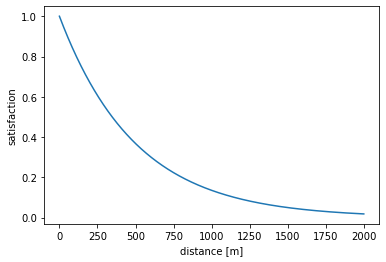

In [9]:
theta = 500

d = np.arange(0, 2000)

plt.plot(d, distance_to_satisfaction(d, theta=theta))
plt.xlabel("distance [m]")
plt.ylabel("satisfaction")

In [10]:
# "satisfaction" at each output area due to a sensor at any other output area
satisfaction = distance_to_satisfaction(distances, theta=theta)

Text(0.5, 1, 'Satisfaction due to sensor at E00042042')

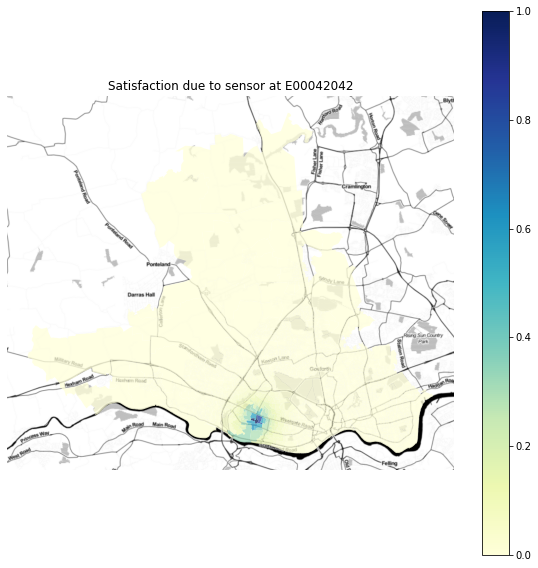

In [11]:
# satisfaction due to sensor at this output area index
sensor_idx = 0

tyne_oa["satisfaction"] = satisfaction[sensor_idx]

ax = tyne_oa.plot(column="satisfaction",
                  figsize=(10,10),alpha=0.75,
                  cmap="YlGnBu", legend=True)

ctx.add_basemap(ax,
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

ax.set_axis_off()
plt.title("Satisfaction due to sensor at " +
          tyne_oa.iloc[sensor_idx]["oa11cd"])

In [12]:
def plot_sensors(sensors,
                 figsize=(20,20),
                 print_sensors=True):
    """
    Plot map with sensor locations (red points), output area centroids (black points),
    and satisfaction (shaded areas).
    """
    # only keep satisfactions due to output areas where a sensor is present
    mask_sat = np.multiply(satisfaction, sensors[np.newaxis, :])

    # satisfaction at each output area = satisfaction due to nearest sensor
    max_mask_sat = np.max(mask_sat, axis=1)

    # population weighted average satisfaction
    avg_satisfaction = (populations * max_mask_sat).sum() / populations.sum()
    
    tyne_oa["satisfaction"] = max_mask_sat

    # to make colorbar same size as graph:
    # https://www.science-emergence.com/Articles/How-to-match-the-colorbar-size-with-the-figure-size-in-matpltolib-/
    ax = plt.figure(figsize=figsize).gca()
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    ax = tyne_oa.plot(column="satisfaction",
                      alpha=0.75,
                      cmap="YlGn", legend=True,
                      ax=ax, cax=cax)


    x = tyne_oa[sensors == 1]["X"]
    y = tyne_oa[sensors == 1]["Y"]
    ax.scatter(x, y, s=24, color='r')

    x = tyne_oa[sensors == 0]["X"]
    y = tyne_oa[sensors == 0]["Y"]
    ax.scatter(x, y, s=4, color='k')


    ctx.add_basemap(ax,
                    url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                    crs=tyne_oa.crs)

    ax.set_axis_off()
    ax.set_title("n_sensors = {:.0f}, satisfaction = {:.2f}".format(sensors.sum(), avg_satisfaction),
                fontsize=20)
    
    # output areas with sensors
    if print_sensors:
        print("Output areas with sensors:",
              tyne_oa[sensors == 1]["oa11cd"].values)

## Baseline 1: place sensors in output areas with largest population

Output areas with sensors: ['E00042147' 'E00042228' 'E00042580' 'E00042600' 'E00042609' 'E00042644'
 'E00042669' 'E00042672' 'E00042673' 'E00042679' 'E00042820' 'E00042877'
 'E00043549' 'E00175564' 'E00175572' 'E00175574' 'E00175578' 'E00175584'
 'E00175591' 'E00175593']


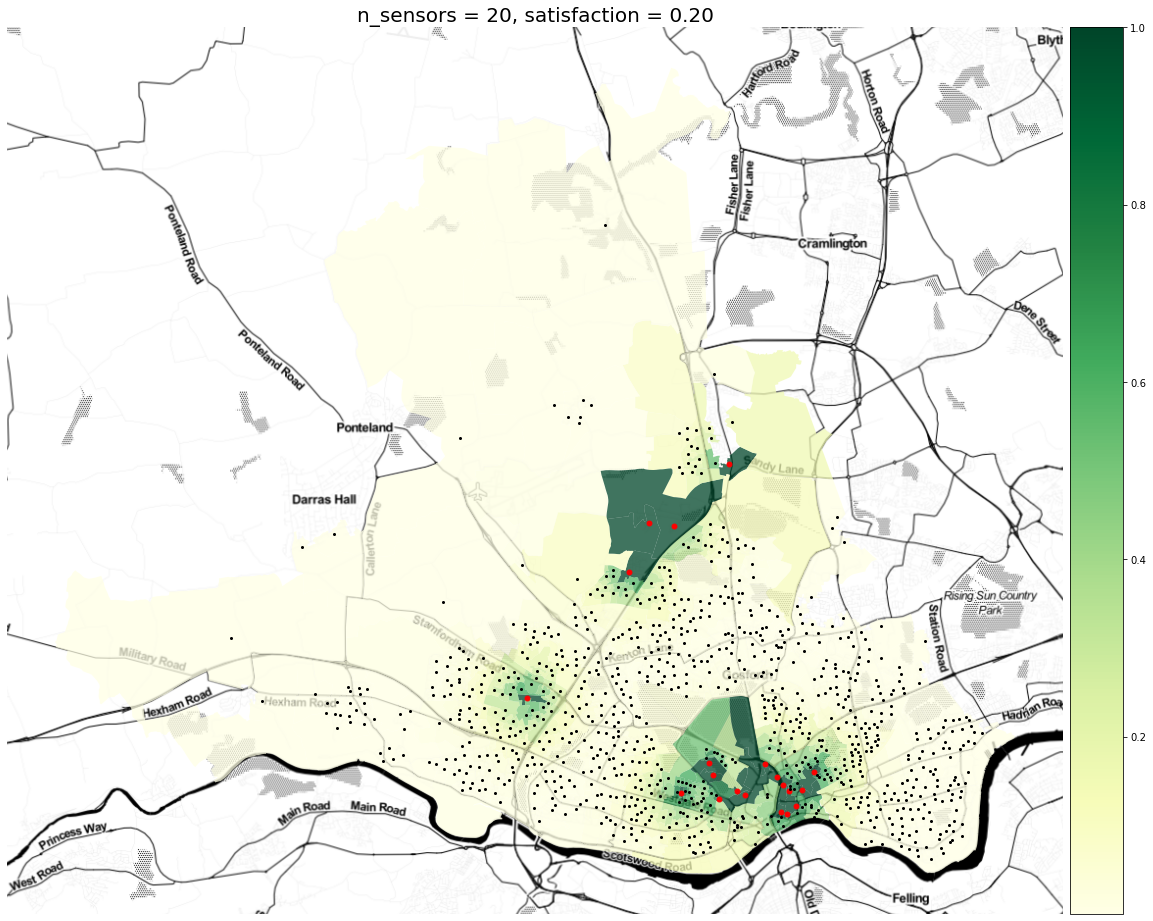

In [13]:
sensors = np.zeros((len(tyne_oa)))

top_idx = tyne_oa["Population"].sort_values(ascending=False).head(n_sensors).index

sensors[top_idx] = 1

plot_sensors(sensors)

## Baseline 2: Place sensors in random output areas

Output areas with sensors: ['E00042053' 'E00042134' 'E00042156' 'E00042218' 'E00042220' 'E00042235'
 'E00042267' 'E00042436' 'E00042470' 'E00042471' 'E00042473' 'E00042536'
 'E00042642' 'E00042712' 'E00042747' 'E00042822' 'E00042924' 'E00042926']


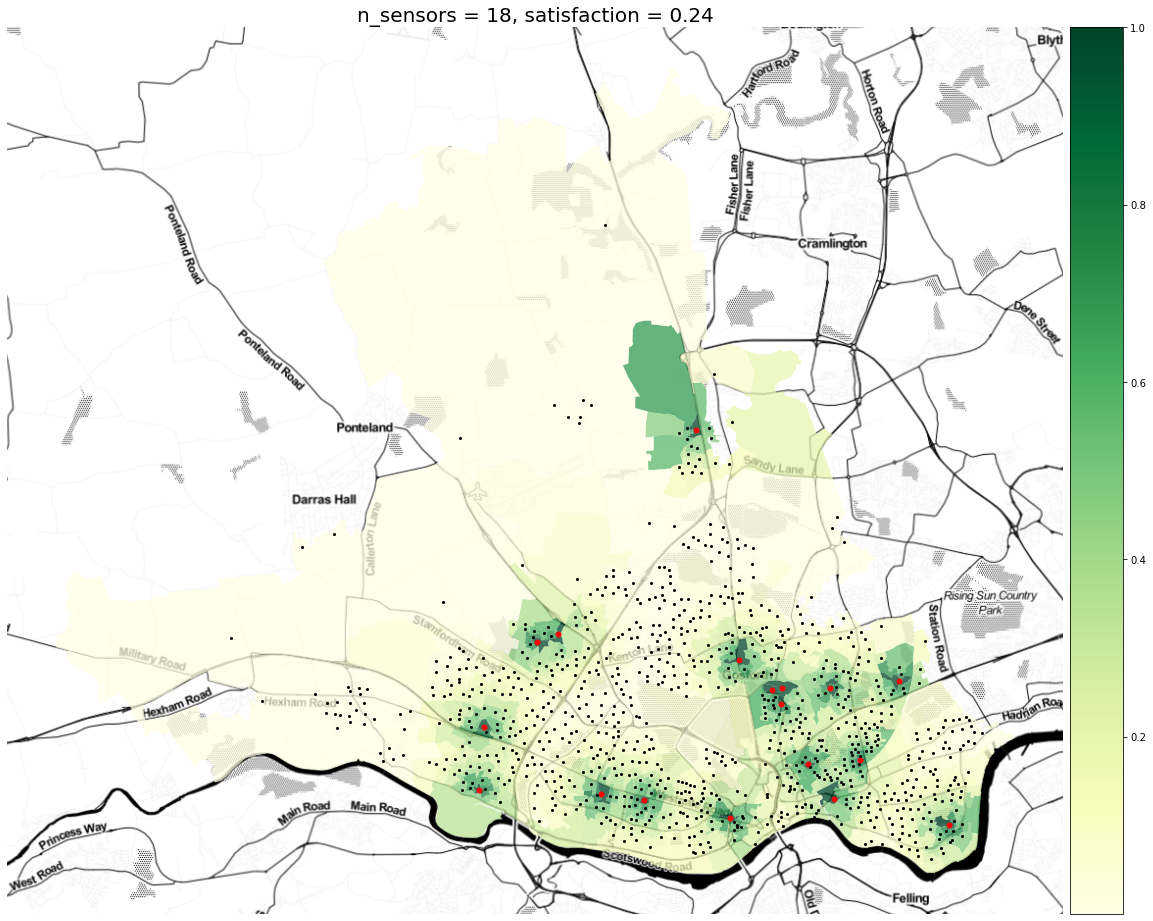

In [14]:
sensors = np.zeros((len(tyne_oa)))

# add sensors at random location
sensor_idx = np.random.randint(0, len(tyne_oa), size=n_sensors)
sensors[sensor_idx] = 1

plot_sensors(sensors)

## Greedy: Place sensors one by one in the place that maximises total satisfaction

Placing sensor 1 out of 20 ... satisfaction = 0.04
Placing sensor 2 out of 20 ... satisfaction = 0.08
Placing sensor 3 out of 20 ... satisfaction = 0.10
Placing sensor 4 out of 20 ... satisfaction = 0.12
Placing sensor 5 out of 20 ... satisfaction = 0.15
Placing sensor 6 out of 20 ... satisfaction = 0.17
Placing sensor 7 out of 20 ... satisfaction = 0.19
Placing sensor 8 out of 20 ... satisfaction = 0.21
Placing sensor 9 out of 20 ... satisfaction = 0.22
Placing sensor 10 out of 20 ... satisfaction = 0.23
Placing sensor 11 out of 20 ... satisfaction = 0.24
Placing sensor 12 out of 20 ... satisfaction = 0.26
Placing sensor 13 out of 20 ... satisfaction = 0.27
Placing sensor 14 out of 20 ... satisfaction = 0.28
Placing sensor 15 out of 20 ... satisfaction = 0.29
Placing sensor 16 out of 20 ... satisfaction = 0.30
Placing sensor 17 out of 20 ... satisfaction = 0.31
Placing sensor 18 out of 20 ... satisfaction = 0.32
Placing sensor 19 out of 20 ... satisfaction = 0.33
Placing sensor 20 out

Text(0, 0.5, 'satisfaction')

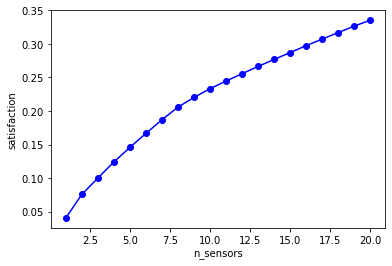

In [15]:
sensors = np.zeros((len(tyne_oa)))

satisfaction_history = []
for s in range(n_sensors):
    # greedily add sensors
    print("Placing sensor", s+1, "out of", n_sensors, "... ", end='')
    
    best_satisfaction = 0
    best_sensors = sensors.copy()
    
    for oa in range(len(tyne_oa)):
        # try adding sensor at each output area
        
        if sensors[oa] == 1:
            # already have a sensor here, so skip to next
            continue
        
        else:
            new_sensors = sensors.copy()
            new_sensors[oa] = 1
            
            # only keep satisfactions due to output areas where a sensor is present
            mask_sat = np.multiply(satisfaction, new_sensors[np.newaxis, :])

            # satisfaction at each output area = satisfaction due to nearest sensor
            max_mask_sat = np.max(mask_sat, axis=1)
            
            # Avg satisfaction = population weighted sum across all output areas
            new_satisfaction = (populations * max_mask_sat).sum() / populations.sum()
            
            if new_satisfaction > best_satisfaction:
                # this output area is the best site for next sensor found so far
                best_sensors = new_sensors.copy()
                best_satisfaction = new_satisfaction
            
    sensors = best_sensors.copy()
    satisfaction_history.append(best_satisfaction)
    print("satisfaction = {:.2f}".format(best_satisfaction))

print("DONE!")
print("Average satisfaction: {:.2f}".format(best_satisfaction))
plt.plot(range(1,n_sensors+1), satisfaction_history, '-bo')
plt.xlabel("n_sensors")
plt.ylabel("satisfaction")

Output areas with sensors: ['E00042043' 'E00042080' 'E00042214' 'E00042255' 'E00042267' 'E00042305'
 'E00042381' 'E00042429' 'E00042447' 'E00042521' 'E00042570' 'E00042621'
 'E00042661' 'E00042662' 'E00042791' 'E00042820' 'E00042846' 'E00042877'
 'E00042886' 'E00175591']


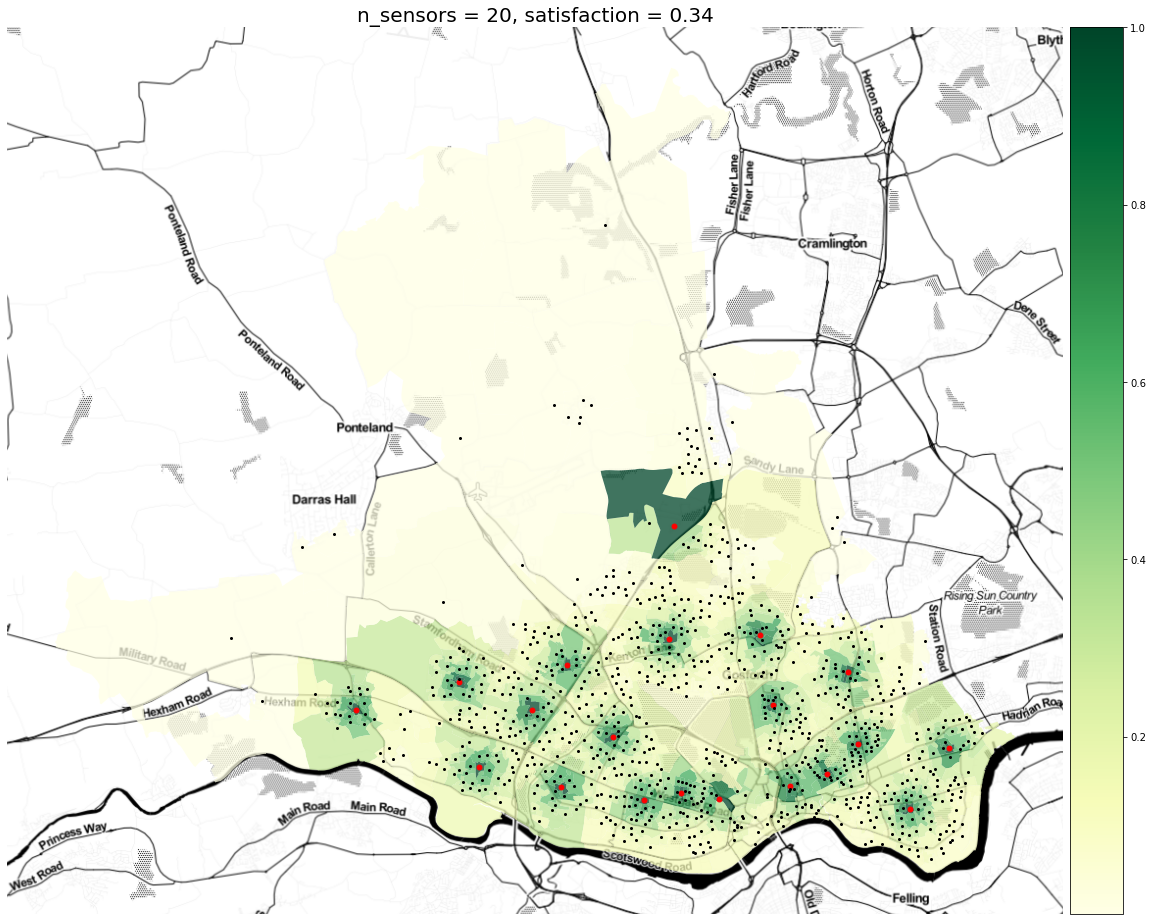

In [16]:
plot_sensors(sensors)

## PyGMO: vector of 0/1s for sensor at location or not

Fails to even meet constraints. But assume it has to "learn" how to make the vector sum up to n_sensors, which seems difficult.

In [17]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, centroids, populations,
                 n_sensors=10, theta=500):
        
        self.n_sensors = n_sensors
        self.centroids = centroids
        self.populations = populations
        
        # dimension of problem = number of candidate sensor locations
        self.dim = len(populations)
        
        self.distances = self._calc_distances(centroids)

        self.distance_to_satisfaction = np.vectorize(self._scalar_satisfaction)        
        self.satisfaction = self.distance_to_satisfaction(distances, theta=theta)
     
    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        # only keep satisfactions due to output areas where a sensor is present
        mask_sat = np.multiply(satisfaction, sensors[np.newaxis, :])

        # satisfaction at each output area = satisfaction due to nearest sensor
        max_mask_sat = np.max(mask_sat, axis=1)
        
        # Total population-weighted satisfaction of solution = our objective
        fitness_sensors = -(self.populations * max_mask_sat).sum() / self.populations.sum()

        # constraint: have n_sensors sensors
        # equality constraints: must equal zero
        constraint_n_sensors = sensors.sum() - self.n_sensors
        
        return [fitness_sensors, constraint_n_sensors]
    

    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        return ([0]*self.dim, [1]*self.dim)
    
    def get_nec(self):
        """PyGMO function.
        Defines number of equality constraints."""
        return 1
    
    def get_nix(self):
        """
        PyGMO function.
        Number of integer dimensions.
        """
        return self.dim
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    
    def _calc_distances(self, centroids):
        dist_sq = np.sum((centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)

        distances = np.sqrt(dist_sq)
        
        return distances
    
    def _scalar_satisfaction(self, distance, theta):
        return np.exp(- distance/ theta)
    


In [18]:
# Build problem
prob = pg.problem(
        population_optimisation(centroids,
                                populations,
                                n_sensors,
                                theta)
      )

print(prob)

Problem name: <class '__main__.population_optimisation'>
	Global dimension:			952
	Integer dimension:			952
	Fitness dimension:			2
	Number of objectives:			1
	Equality constraints dimension:		1
	Inequality constraints dimension:	0
	Tolerances on constraints: [0]
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [1, 1, 1, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 1904
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [19]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.gaco())
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=100)


Algorithm name: GACO: Ant Colony Optimization [stochastic]
	Thread safety: basic

Extra info:
	Generations: 100
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 1792535178 3246451672 756170857 2609551984 3681808638 4087380182 684501263 2460006898 846908344 3548370849 423871732 2395949135 3147021165 77617624 943721030 1185776557 3886022380 3457579868 3397223309 2412635417 2475939515 1112258578 3118910101 412728490 3678693674 1248030278 2268037405 1571850326 3724368239 734204857 1066649883 262851270 2823812670 1039548877 2214177539 3339387016 309238267 2414285612 1571827532 116252296 2108134352 2012162718 2374232037 930487630 3429518834 1463662914 3360944797 1078412933 511145540 3746041093 2307873168 125532365 3505872405 2911626467 2211755515 3726445684 3093469739 109429606 2283908472 4051024733 206191186 3267159191 2598724

In [20]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("n_sensors", pop.champion_x.sum())
print("min sensors at location", pop.champion_x.min())
print("max sensors at location", pop.champion_x.max())

f evals 10100
g evals 0
champion f [ -0.80829032 392.        ]
n_sensors 412.0
min sensors at location 0.0
max sensors at location 1.0


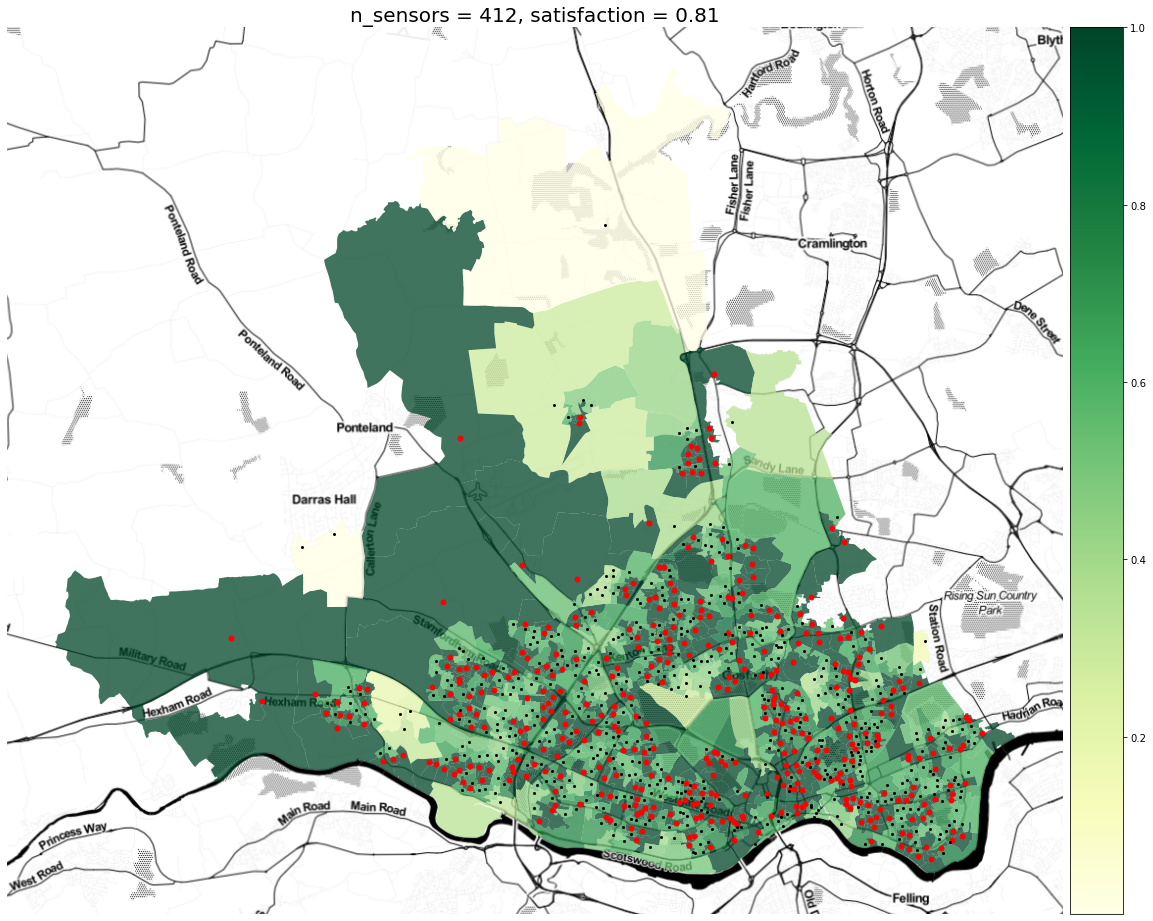

In [21]:
plot_sensors(pop.champion_x, print_sensors=False)

## PyGMO: Sensors at any arbitrary position (not only output area centroids)

In [114]:
# PyGMO User Defined Problem
class population_optimisation:
    def __init__(self, centroids, populations,
                 n_sensors=20, theta=500):
        
        self.n_sensors = n_sensors
        self.centroids = centroids
        self.populations = populations
        self.theta = theta
        
        self.distance_to_satisfaction = np.vectorize(self._scalar_satisfaction)        
     
    def fitness(self, sensors):
        """
        PyGMO required function.
        The objective function to minimise. And constraints to evaluate.
        """
        
        # convert 1D sensors vector into 2D array of X,Y coordinates
        sensors = sensors.reshape(self.n_sensors, 2)
        
        # calculate distance between sensors and output area centroids
        distances = self.calc_distances(sensors, centroids)

        # convert distances to satisfaction values
        # (satisfaction at each output area due to each sensor)
        satisfaction = self.distance_to_satisfaction(distances, theta=self.theta)
        

        # satisfaction at each output area = satisfaction due to nearest sensor
        max_sat = np.max(satisfaction, axis=0)
        
        # Total population-weighted satisfaction of solution = our objective
        fitness_sensors = -(self.populations * max_sat).sum() / self.populations.sum()

        return [fitness_sensors]
    
    def get_bounds(self):
        """
        PyGMO required function.
        Defines min and max value for each parameter.
        """
        min_xy = self.centroids.min(axis=0)
        max_xy = self.centroids.max(axis=0)
        
        return (list(min_xy)*self.n_sensors,
                list(max_xy)*self.n_sensors)
    
    def gradient(self, x):
        return pg.estimate_gradient_h(lambda x: self.fitness(x), x)
    
    def calc_distances(self, sensors, centroids):
        """distance between sensor locations and output area centroids"""
        dist_sq = np.sum((sensors[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                         axis = -1)

        distances = np.sqrt(dist_sq)
        
        return distances
    
    def _scalar_satisfaction(self, distance, theta):
        return np.exp(- distance/ theta)
    


In [115]:
# Build problem
prob = pg.problem(
        population_optimisation(centroids,
                                populations,
                                n_sensors,
                                theta)
      )

print(prob)

Problem name: <class '__main__.population_optimisation'>
	Global dimension:			40
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [413067, 563224, 413067, 563224, 413067, ... ]
	Upper bounds: [429850, 577386, 429850, 577386, 429850, ... ]
	Has batch fitness evaluation: false

	Has gradient: true
	User implemented gradient sparsity: false
	Expected gradients: 40
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0
	Gradient evaluations: 0

	Thread safety: none



In [116]:
# Create algorithm to solve problem with
algo = pg.algorithm(uda = pg.gaco(gen=200))
algo.set_verbosity(1)
print(algo)

# population of problems
pop = pg.population(prob=prob, size=200)

Algorithm name: GACO: Ant Colony Optimization [stochastic]
	Thread safety: basic

Extra info:
	Generations: 200
	Accuracy parameter: 0.01
	Improvement stopping criterion: 100000
	Evaluation stopping criterion: 100000
	Focus parameter: 0
	Kernel: 63
	Oracle parameter: 0
	Pseudo-random number generator (Marsenne Twister 19937): 1746492099 4141916299 1614814634 1020868474 1018768678 1380066819 3162378448 3799712993 2857623346 1876409849 1720691426 3377915546 3403668329 2393066207 4052209215 3952507323 1837727144 2266825918 1193245246 3549426158 431835029 1141832414 3460518161 913284657 889758317 4165954074 3922410743 2608439391 207161805 1174049534 1300198841 2706434487 2985365897 1431064312 2989320543 3067631316 2444019858 745550069 1160342991 1572704365 4043818692 2766334892 1466505680 2617182368 2611681814 570555921 2587317731 3119598324 1376401726 4217654540 1261989405 3002363199 563068485 2053897838 3771582721 684744705 2845665693 536462068 2341109374 4038607655 2593964400 1165775927

In [117]:
# solve problem
pop = algo.evolve(pop)

print("f evals", pop.problem.get_fevals())
print("g evals", pop.problem.get_gevals())
print("champion f", pop.champion_f)
print("sensors", pop.champion_x)

f evals 40200
g evals 0
champion f [-0.24623779]
sensors [418184.29424868 564753.96821561 424667.92951055 569194.73574935
 429201.53010956 565456.94279649 423822.56234106 568732.5977366
 416104.67275199 566783.86818558 422353.82173815 564459.40146392
 421320.63471647 565292.39654204 418809.13480689 566960.81905521
 426743.3799463  564150.06850528 421752.28251847 565766.94004607
 427255.56051425 566045.09282054 425680.53797876 565463.42245203
 416041.86086904 572868.95145829 423625.88916352 564284.03530494
 413998.22075506 575611.75954527 423671.90465696 565255.80688041
 420627.99001842 567004.85010097 420605.78156052 567805.61531285
 425190.01320916 573314.04644109 424336.55712377 567313.75399025]


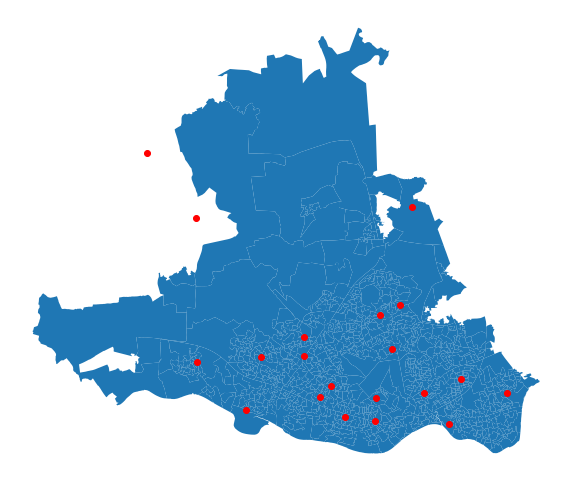

In [118]:
ax = tyne_oa.plot(figsize=(10,10))
ax.set_axis_off()

sensors = pop.champion_x
sensors = sensors.reshape(n_sensors, 2)
sensors_x = sensors[:, 0]
sensors_y = sensors[:, 1]
ax.scatter(sensors_x,sensors_y, color='r')

## MIP

In [27]:
from mip.model import *

Using Python-MIP package version 1.6.4


In [28]:
m = Model(sense=MAXIMIZE)

# sensors: yes/no at each output area
x = [m.add_var(var_type=BINARY) for i in range(len(populations))]

# sum of sensors vector should equal number of sensors
m.add_constr( xsum(x[i] for i in range(len(populations))) == n_sensors,
             "constraint_n_sensors")


# objective function
def obj_function(sensors):
    sensors = np.array([sensor.x if sensor.x is not None else 0 for sensor in sensors])
    
    mask_sat = np.multiply(satisfaction, sensors[np.newaxis, :])

    # satisfaction at each output area = satisfaction due to nearest sensor
    max_mask_sat = np.max(mask_sat, axis=1)

    # Total population-weighted satisfaction of solution = our objective
    return (populations * max_mask_sat).sum() / populations.sum()

m.objective = maximize(obj_function(x))


AttributeError: 'numpy.float64' object has no attribute 'sense'

In [ ]:
x[0].

In [ ]:
len(populations)

In [ ]:
centroids.shape

In [ ]:
t = np.array(range(40))

In [ ]:
t = t.reshape(20,2)

In [ ]:
t

In [ ]:
x=np.sum((t[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)
x.shape

In [ ]:
np.max(x, axis=0).shape

In [ ]:
min_xy = centroids.min(axis=0)
max_xy = centroids.max(axis=0)
min_xy

In [ ]:
list(min_xy)*n_sensors

In [ ]:
tyne_oa.crs

In [ ]:
t = [0,0,0,1,0]
[i for i in t if i==1]

In [ ]:
tyne_oa

## scipy optimize

In [86]:
prob =         population_optimisation(centroids,
                                populations,
                                n_sensors,
                                theta)

In [88]:
def temp1(x):
    q1 = prob.fitness(x)
    print(q1)
    return q1[0]

In [89]:
413067.0710000005 429849.7170000002
563224.0130000003 577386.1339999996


SyntaxError: invalid syntax (<ipython-input-89-636d49fb4cf2>, line 1)

In [90]:
from scipy import optimize

points = optimize.minimize(temp1, sensors.reshape(40,))

[-0.07440063712416989]
[-0.07440063712416989]
[-0.07440063712417133]
[-0.07440063712416697]
[-0.07440063712416752]
[-0.07440063712416423]
[-0.07440063712416989]
[-0.07440063712416989]
[-0.07440063712426226]
[-0.07440063712409142]
[-0.07440063712422973]
[-0.07440063712416002]
[-0.07440063712416989]
[-0.07440063712416989]
[-0.07440063712416804]
[-0.07440063712416187]
[-0.07440063712416989]
[-0.07440063712416989]
[-0.07440063712417297]
[-0.07440063712417011]
[-0.07440063712417402]
[-0.07440063712427437]
[-0.07440063712423864]
[-0.07440063712409918]
[-0.07440063712424111]
[-0.07440063712407186]
[-0.07440063712416989]
[-0.07440063712416989]
[-0.07440063712421814]
[-0.07440063712408299]
[-0.07440063712417358]
[-0.07440063712415004]
[-0.07440063712418883]
[-0.07440063712423088]
[-0.07440063712412544]
[-0.07440063712417312]
[-0.07440063712416989]
[-0.07440063712416989]
[-0.07440063712416517]
[-0.07440063712419245]
[-0.07440063712416989]
[-0.07440063712416989]


In [96]:
points = optimize.minimize(temp1,[(413067.0710000005+429849.7170000002)/2 if x%2==0 else (563224.0130000003+577386.1339999996)/2  for x in range(40)])

[-0.004671948229816732]
[-0.004671948229816732]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.0046719482298805005]
[-0.004671948229826221]
[-0.00467194822988050

In [94]:
points1 = optimize.differential_evolution(temp1,[[413067.0710000005,429849.7170000002] if x%2==0 else [563224.0130000003, 577386.1339999996]  for x in range(40)])

[-0.07491379794326403]
[-0.1336675919660744]
[-0.06398037002864669]
[-0.0780276794483366]
[-0.07013326815816993]
[-0.12328134542138615]
[-0.08056863352634236]
[-0.06425139565945656]
[-0.14494334507825168]
[-0.09703992555764002]
[-0.08550332350582408]
[-0.1080413179856665]
[-0.08925776011810911]
[-0.1313984322515928]
[-0.10851283698718418]
[-0.06984628131175383]
[-0.07650025610887105]
[-0.08892309692334574]
[-0.08239198134267313]
[-0.12916629876413574]
[-0.06687918010275003]
[-0.1411797822429484]
[-0.08491953055313088]
[-0.10865164792587977]
[-0.11443384730805488]
[-0.08811312035940838]
[-0.14381251280580612]
[-0.09347477323461584]
[-0.08277024378140549]
[-0.0654543655505079]
[-0.10864801186452486]
[-0.14921924597888178]
[-0.10094634917482345]
[-0.13441235060457254]
[-0.09892029358055876]
[-0.07313976171059694]
[-0.11140636157007615]
[-0.043589353176388825]
[-0.09408241298962125]
[-0.06151853959270545]
[-0.08738894386614622]
[-0.10368613613518328]
[-0.08176689072948196]
[-0.105109428560

[-0.09642573347281658]
[-0.1134730017813763]
[-0.117046216014838]
[-0.09664231668741347]
[-0.10116937060141226]
[-0.08147749651168786]
[-0.11512741703689242]
[-0.13283900369103593]
[-0.12324212531017527]
[-0.10370025511152944]
[-0.022521744751001126]
[-0.10185541005908146]
[-0.12408523331484145]
[-0.09154617922283156]
[-0.03371790008991701]
[-0.12412598505870182]
[-0.05784225839712723]
[-0.08572495863452766]
[-0.07252191892479591]
[-0.13356214492624746]
[-0.10938740401377835]
[-0.09819193049749685]
[-0.057346055222528426]
[-0.05450108309899025]
[-0.057251249188613]
[-0.08965395273663661]
[-0.11845735536056595]
[-0.078755869635207]
[-0.052754501190760326]
[-0.07477455141708557]
[-0.10384992447094282]
[-0.08560198047807155]
[-0.11062424411658463]
[-0.08834103249703472]
[-0.07383953355895631]
[-0.1288405394006792]
[-0.06727040734223036]
[-0.11203513263804227]
[-0.06769016220684505]
[-0.12532637655346315]
[-0.12082206884303226]
[-0.15503084442025367]
[-0.1250700531983215]
[-0.1182008320368

[-0.08250913042867616]
[-0.11390184712194308]
[-0.11657306064966075]
[-0.08358312905051371]
[-0.11897275986566146]
[-0.06834064683688243]
[-0.11650164193320087]
[-0.13005273017085403]
[-0.05639076567885731]
[-0.13375059517351762]
[-0.08485348583415944]
[-0.11874716709157143]
[-0.14044977762397656]
[-0.1266699449824928]
[-0.08904997151173674]
[-0.06682083847370697]
[-0.09169664981120718]
[-0.11055862063452924]
[-0.12844525066358256]
[-0.12112592843394981]
[-0.09367713704841617]
[-0.10915236863649723]
[-0.11174164997088779]
[-0.04657155506626493]
[-0.07306073127397959]
[-0.08757959094511504]
[-0.08856080311006276]
[-0.10801089913978386]
[-0.14966491146335098]
[-0.11856473022086632]
[-0.1461542269587499]
[-0.11054897083676243]
[-0.07577529232337601]
[-0.11501706252579379]
[-0.08291660681458493]
[-0.10087982368590388]
[-0.07239136744435798]
[-0.10843498827773836]
[-0.13113247571262793]
[-0.13526149766079412]
[-0.11259285931812908]
[-0.07203501885305308]
[-0.08539434049702371]
[-0.083266116

[-0.11391828280005155]
[-0.1627066559057206]
[-0.11434784577099445]
[-0.09965627503858432]
[-0.07000181654511411]
[-0.10339265003276248]
[-0.08429845948332086]
[-0.11821378131007759]
[-0.12457264134130099]
[-0.1553152380956645]
[-0.10490646789178013]
[-0.14639265025828072]
[-0.12610314123584743]
[-0.13477620971817092]
[-0.12926529218047914]
[-0.1341039525399975]
[-0.06569254211336009]
[-0.09611005422353852]
[-0.09907901329361753]
[-0.1266188299079355]
[-0.1204010609019649]
[-0.1117238347666067]
[-0.08717426282099539]
[-0.11602812341970796]
[-0.1570379230688577]
[-0.1036740478706651]
[-0.08532562066175217]
[-0.1458932160061058]
[-0.10458711316307731]
[-0.14026550178683536]
[-0.09696455552305754]
[-0.08009656766367065]
[-0.06782799886676827]
[-0.10878902549798404]
[-0.11851439501113925]
[-0.1294800459537253]
[-0.14083668064483887]
[-0.09995046027606495]
[-0.09407293444895154]
[-0.12908711237950654]
[-0.10807149011147324]
[-0.13613987759193158]
[-0.07444071020037239]
[-0.10808007094821497

[-0.12986528084794866]
[-0.07529422257018731]
[-0.1232382961374934]
[-0.10797943636914636]
[-0.055108914402172804]
[-0.09229393221026061]
[-0.10861318368968471]
[-0.082154142847959]
[-0.07895942846647226]
[-0.06231257943133992]
[-0.09621749570766037]
[-0.10507821690189209]
[-0.05354129916701565]
[-0.15728814356645876]
[-0.11183402174089911]
[-0.11740960957025524]
[-0.11343401079064952]
[-0.12520397806020214]
[-0.13249687741358154]
[-0.1187901411506759]
[-0.12893997971739382]
[-0.07307779781512412]
[-0.11158457105996998]
[-0.12609117870908448]
[-0.09989582471652206]
[-0.20802615781658104]
[-0.14231988640687443]
[-0.12935193356985]
[-0.06443433382703345]
[-0.13381569954484152]
[-0.12167463784624709]
[-0.10159019006770535]
[-0.13474944422499938]
[-0.12155625848602851]
[-0.11340267562952426]
[-0.12359943071796084]
[-0.0848779759019245]
[-0.1268986523784723]
[-0.128370057786283]
[-0.14315335208512447]
[-0.13519847428510093]
[-0.116328081724677]
[-0.0861089379649242]
[-0.07405894970799676]
[

[-0.11157904318395341]
[-0.12873866429639028]
[-0.11646021065832736]
[-0.07627180818429395]
[-0.12158547164359083]
[-0.15175723541112865]
[-0.14999447023103893]
[-0.11755002292721832]
[-0.07853406471921535]
[-0.1744200037577462]
[-0.1042953534242513]
[-0.14457015148513297]
[-0.14084601741370675]
[-0.1277910000836733]
[-0.12586859040562698]
[-0.14770571133303095]
[-0.04299426213838442]
[-0.12380687621902205]
[-0.12452022508130298]
[-0.11512918618788802]
[-0.06554232488006774]
[-0.16816713836351843]
[-0.14965834160046482]
[-0.08947726878239409]
[-0.12448438003493865]
[-0.120181573943935]
[-0.11600839256598326]
[-0.08490440593717363]
[-0.11971305063347722]
[-0.11334533781580357]
[-0.1393913698447728]
[-0.13275828244124763]
[-0.16065497074501423]
[-0.16176754623095105]
[-0.1058682012093917]
[-0.07158108280875287]
[-0.13396190106145894]
[-0.10002330096383501]
[-0.09326521061447778]
[-0.11102164353421505]
[-0.1066760422407404]
[-0.04548271199965987]
[-0.18208672038844156]
[-0.145527554070473

[-0.08048909367724635]
[-0.13491820286315698]
[-0.16109943362789575]
[-0.16776564856949636]
[-0.09002184086533066]
[-0.1374271367312052]
[-0.12296339131597686]
[-0.16441983040803582]
[-0.08596203358012797]
[-0.12118119761045233]
[-0.10517574701072441]
[-0.10917876871085289]
[-0.11206017674245568]
[-0.14528343712234126]
[-0.13128589791550055]
[-0.12563010738885363]
[-0.0930686741151184]
[-0.13224808402756136]
[-0.13969827691513867]
[-0.10673278306258044]
[-0.13949029832867804]
[-0.16388468582994842]
[-0.11524274081230236]
[-0.13342245948529133]
[-0.10687750868604844]
[-0.14930693471435602]
[-0.14851155699914123]
[-0.10122489006904486]
[-0.13675617917707963]
[-0.10454827144768529]
[-0.11301572851956013]
[-0.1330578166694068]
[-0.15180138464570878]
[-0.13730100402181528]
[-0.16409419788913351]
[-0.09956695503169921]
[-0.14457551295625706]
[-0.1408123832698025]
[-0.13961313617110846]
[-0.1473082198995252]
[-0.10866225754101198]
[-0.14329388674767318]
[-0.1595759525787971]
[-0.0851077352636

[-0.12433910219904858]
[-0.1256568871983223]
[-0.10253945742500628]
[-0.10152831517145244]
[-0.08711065500491497]
[-0.15157600250586067]
[-0.15871625010477872]
[-0.1631961291716578]
[-0.12950939596272534]
[-0.08486522290165982]
[-0.1678231566017648]
[-0.12245906889173414]
[-0.10822560511327911]
[-0.17729766254754242]
[-0.13391394274428867]
[-0.16478324816576562]
[-0.10411368900161372]
[-0.12644004675773082]
[-0.14829214643297356]
[-0.14019451788089696]
[-0.11570371048327091]
[-0.16780116595872827]
[-0.10081271426652165]
[-0.11902630197800913]
[-0.11368658619105601]
[-0.08174909417368055]
[-0.12912631081645382]
[-0.1464331505585326]
[-0.12877196124753715]
[-0.11803197690070646]
[-0.13433910121604006]
[-0.1256294242671703]
[-0.12118539804223728]
[-0.16087548774723615]
[-0.14918630383359383]
[-0.14668391405591494]
[-0.1440688162166072]
[-0.10993814644610417]
[-0.12957068621753678]
[-0.1362793252570252]
[-0.14012048493232318]
[-0.11468927782595233]
[-0.12945790665042847]
[-0.11869809057734

[-0.13904839453647083]
[-0.10755282465788574]
[-0.16619839335320863]
[-0.12017638369528176]
[-0.17280610066514404]
[-0.11246486361542138]
[-0.09393514281050841]
[-0.11756986156656975]
[-0.11195613984343401]
[-0.15065583377347916]
[-0.0786599007214732]
[-0.05693200176136779]
[-0.14117957451889585]
[-0.08632246984438241]
[-0.1146590481859968]
[-0.1044452997288313]
[-0.08415138684002821]
[-0.14857384313511396]
[-0.1623434921637812]
[-0.09630504268592968]
[-0.15379282444568976]
[-0.13739405656946566]
[-0.09333836422115595]
[-0.09791020235048618]
[-0.11624708291475097]
[-0.1655121538572947]
[-0.14747758552784462]
[-0.1069380518053031]
[-0.10358755307908502]
[-0.11672397933519352]
[-0.12473784377282626]
[-0.07328888113659435]
[-0.13981680220709683]
[-0.0886391237387242]
[-0.1070985481185191]
[-0.13774092817628392]
[-0.1292020292604495]
[-0.10832411198713159]
[-0.15770301834588732]
[-0.11782427434436354]
[-0.10835638717802991]
[-0.16488786265843697]
[-0.12955570393058477]
[-0.1406771338961961

[-0.16186790254576236]
[-0.16738343627352134]
[-0.1723067024066689]
[-0.1651465691445291]
[-0.1715613950699904]
[-0.11277104973497841]
[-0.1196106003738123]
[-0.1329702327030941]
[-0.10674440273139404]
[-0.16515038914356867]
[-0.1309088467243476]
[-0.11176150349221668]
[-0.13171861435606388]
[-0.15068642562565346]
[-0.1461501649416497]
[-0.08877997076242625]
[-0.16451888282091892]
[-0.0996263741502343]
[-0.1446673300408444]
[-0.10438039786124241]
[-0.18575258544385498]
[-0.14804812509975884]
[-0.11581621358761901]
[-0.13577591349894833]
[-0.14446281586205667]
[-0.11025466467722117]
[-0.13789331030867907]
[-0.14632970101940482]
[-0.17606630423381261]
[-0.15314716965666844]
[-0.12606319009165756]
[-0.16489670643135843]
[-0.13293426892930982]
[-0.1653490825549964]
[-0.17495709336052986]
[-0.1550334237493593]
[-0.13609938327708618]
[-0.11047043991885572]
[-0.1309235916064122]
[-0.12013298127551358]
[-0.10207639618615183]
[-0.139428989389469]
[-0.12411910687602841]
[-0.11181993413438321]
[-

[-0.1751578466878433]
[-0.08382652555097769]
[-0.17159777599886944]
[-0.18851493408435663]
[-0.1400368713698352]
[-0.13798914009897642]
[-0.17927873923716833]
[-0.12261913598957547]
[-0.16681678138383785]
[-0.16294876281165183]
[-0.16097719911638148]
[-0.14079019460719724]
[-0.09401610213108465]
[-0.08539420499326164]
[-0.14946985684849]
[-0.14792436251583033]
[-0.18679721189791937]
[-0.14406205629112637]
[-0.14714807614375658]
[-0.13350713286080695]
[-0.10237271713931476]
[-0.16365348165530053]
[-0.12592494811392285]
[-0.10978677123895635]
[-0.14397878478899911]
[-0.1634498190539297]
[-0.15317426761603872]
[-0.13611885363017456]
[-0.1314703230007225]
[-0.16612145537993717]
[-0.1342455165405968]
[-0.1248737387113715]
[-0.11836762639610579]
[-0.16206781964083541]
[-0.1363315016881255]
[-0.13153398964852694]
[-0.15292239674186806]
[-0.1696888764523974]
[-0.15391317982192504]
[-0.1337255652399548]
[-0.15800578901344478]
[-0.12621477708344947]
[-0.16675920494418325]
[-0.14216754198073578]


[-0.14627604608322894]
[-0.10664236425525898]
[-0.16430271157655776]
[-0.12538903306866755]
[-0.13423020858430645]
[-0.16922365969504413]
[-0.1486056125684281]
[-0.1863736801769231]
[-0.1250915368486373]
[-0.08093984715866558]
[-0.10269831546466662]
[-0.14354489449740343]
[-0.1495224941334777]
[-0.11810997388129771]
[-0.12497395545958068]
[-0.16756054976305185]
[-0.18681086225550383]
[-0.16980828713847557]
[-0.13655634033963765]
[-0.16297514709422029]
[-0.13525257147332861]
[-0.12119288549832588]
[-0.13458053881239077]
[-0.1458127975851163]
[-0.08445528790205717]
[-0.1533258271994417]
[-0.15276239236259284]
[-0.126434221537984]
[-0.13706641285927657]
[-0.1316447092974131]
[-0.1288485169209044]
[-0.1349547921988506]
[-0.12873927896952456]
[-0.10400525100352072]
[-0.18503820555986314]
[-0.18658404382542806]
[-0.1403694076317047]
[-0.15812079199822993]
[-0.1247744523297953]
[-0.13949469006103163]
[-0.12949263728149704]
[-0.13010457993280444]
[-0.14516282859000346]
[-0.14301675128057822]
[

[-0.14511890421315898]
[-0.10589156281582383]
[-0.1109984070863139]
[-0.13463634871182445]
[-0.17420268509617998]
[-0.12622562328579748]
[-0.1583460416264157]
[-0.14234127936057314]
[-0.1456028404581268]
[-0.11147758164932182]
[-0.16201539628252085]
[-0.09732902249364139]
[-0.12051930897101115]
[-0.17093727886294213]
[-0.17345218506050258]
[-0.10788841083865469]
[-0.16632599375039053]
[-0.19425706758983524]
[-0.12657769818899367]
[-0.16060192848786203]
[-0.12987575095596463]
[-0.13559655829946413]
[-0.18713822567690774]
[-0.12186305235028765]
[-0.13517135567182378]
[-0.09490198499048579]
[-0.10885442786869813]
[-0.16405240543919627]
[-0.14522528838400137]
[-0.12445193590338441]
[-0.0823355889288889]
[-0.19425706334686177]
[-0.1281630708475729]
[-0.15211712335399194]
[-0.1472734900839402]
[-0.10605011877458549]
[-0.12223892919280596]
[-0.17197636097551244]
[-0.16121201965991122]
[-0.13880537829215503]
[-0.15205477514319862]
[-0.12331629203801385]
[-0.14465971317118942]
[-0.1040689070610

[-0.13585651034310353]
[-0.13053061677183167]
[-0.1396156084331785]
[-0.11927210611631793]
[-0.0770035010829393]
[-0.17000421134596844]
[-0.1257762871400554]
[-0.15355991963036023]
[-0.1562562627225855]
[-0.1740925829490628]
[-0.11903703863612318]
[-0.1293257825872082]
[-0.12103680377314333]
[-0.13227740986174072]
[-0.19910581984920295]
[-0.09709701904983951]
[-0.11059867674347472]
[-0.1337311371359117]
[-0.11043042044970593]
[-0.1673758970828678]
[-0.15602762302194245]
[-0.16744064256564334]
[-0.12011276063379625]
[-0.09104158824738078]
[-0.1534781229822188]
[-0.09843408708417503]
[-0.15112061938202268]
[-0.1401379056215815]
[-0.14083358771774296]
[-0.15984708582412654]
[-0.12977847797303635]
[-0.08567417578429401]
[-0.12531842343405827]
[-0.16315919916450508]
[-0.09839490725967565]
[-0.0947111217351254]
[-0.10642385770752896]
[-0.14077019306111463]
[-0.11533390072569857]
[-0.1269943693853031]
[-0.14801233491912522]
[-0.14628498273594812]
[-0.15977750340477323]
[-0.12841292368056928]


[-0.1540326792961414]
[-0.15256416973614317]
[-0.11216478040533806]
[-0.10117627452795099]
[-0.13759841012422408]
[-0.10867374260110059]
[-0.10542496060771933]
[-0.12648412075267582]
[-0.12136942758784915]
[-0.1599935723380463]
[-0.05245099068552892]
[-0.09227844264564866]
[-0.15430524390204]
[-0.1285939568815306]
[-0.12096448202556265]
[-0.14834910158875853]
[-0.17170071691551156]
[-0.11644244737823664]
[-0.08964095746923821]
[-0.13857844404853145]
[-0.14729444453952145]
[-0.1563140872149914]
[-0.11575837133395796]
[-0.17246275282160892]
[-0.13901233664783494]
[-0.106800374180192]
[-0.16625880315484504]
[-0.14750955151029438]
[-0.14054567253951022]
[-0.14382444779472064]
[-0.1265333484928701]
[-0.11355233189553593]
[-0.13881002207004567]
[-0.13649690417663252]
[-0.113039560390354]
[-0.17283456304179623]
[-0.17887391020067595]
[-0.1401595410506941]
[-0.13917852233171218]
[-0.17584434728486997]
[-0.14452495677356372]
[-0.1439242980505581]
[-0.15176026133960946]
[-0.11791614188767009]
[-

KeyboardInterrupt: 

In [92]:
temp1(sensors.reshape(40,))

[-0.07440063712416989]


-0.07440063712416989

In [91]:
points

      fun: -0.07440063712416989
 hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])
      jac: array([-9.68575478e-08,  1.95577741e-07,  1.59256160e-07,  3.79979610e-07,
        0.00000000e+00,  0.00000000e+00, -6.19888306e-06,  5.26569784e-06,
       -4.01586294e-06,  6.62170351e-07,  0.00000000e+00,  0.00000000e+00,
        1.23865902e-07,  5.38304448e-07,  0.00000000e+00,  0.00000000e+00,
       -2.06753612e-07, -1.49011612e-08, -2.77534127e-07, -7.01192766e-06,
       -4.61377203e-06,  4.74508852e-06, -4.77954745e-06,  6.57886267e-06,
        0.00000000e+00,  0.00000000e+00, -3.23820859e-06,  5.83194196e-06,
       -2.47731805e-07,  1.33179128e-06, -1.27125531e-06, -4.09316272e-06,
        2.98302621e-06, -2.16998160e-07,  0.00000000e+00,  0.00000000e+00,
        3.16649675e-07, -1.51433051e-06,  0.00000000e+00,  0.00000

In [73]:
satisfaction

array([[6.31668735e-10, 6.08191323e-10, 4.30131380e-10, ...,
        1.03583022e-07, 1.58131463e-07, 1.73232413e-03],
       [2.14807890e-08, 7.34414579e-09, 6.43081058e-09, ...,
        6.63688161e-07, 8.64368185e-07, 6.92013353e-05],
       [1.35294347e-12, 6.53832420e-13, 5.21492815e-13, ...,
        1.11025541e-10, 1.60558990e-10, 9.02202843e-07],
       ...,
       [4.10548705e-11, 3.55724516e-11, 2.55076070e-11, ...,
        6.52491509e-09, 9.95501046e-09, 1.48809975e-04],
       [5.80456359e-08, 2.50911160e-07, 1.75837337e-07, ...,
        3.74485038e-07, 3.95353174e-07, 1.58014460e-08],
       [9.64194885e-10, 3.25146360e-09, 2.18630272e-09, ...,
        2.34383022e-08, 2.85066985e-08, 3.90897307e-08]])

In [83]:
max_sat.shape

(952,)

In [84]:
fitness_sensors

-0.07440063712416989

In [110]:
centroids.min(axis=0)

array([413067.071, 563224.013])

In [111]:
centroids.max(axis=0)

array([429849.717, 577386.134])

In [113]:
min_xy = centroids.min(axis=0)
max_xy = centroids.max(axis=0)
        
(list(min_xy)*n_sensors, list(max_xy)*n_sensors)
    

([413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003,
  413067.0710000005,
  563224.0130000003],
 [429849.7170000002,
  577386.1339999996,
  429849.7170000002,
  577386.1339999996,
  429849.7170000002,
  577386.1339999996,
  429849.7170000002,
  577386.133